<a href="https://colab.research.google.com/github/avishreekh/Medical-Image-Analysis/blob/master/qureai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pydicom
# !pip install pandas-profiling
# !pip install gdcm
!pip install SimpleITK

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import pydicom as pdicom
from glob import glob
import SimpleITK as sitk
# import gdcm
# import pandas_profiling

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
base_dir = os.path.join('drive/My Drive')
img_dir = os.path.join(base_dir,'images')
csv_file = os.path.join(base_dir, 'new.csv')
df = pd.read_csv(csv_file)
df['image_name'] = df.apply(lambda row: ''.join(row['name'].split('-')), axis=1)
df['path'] = df.apply(lambda row: os.listdir(os.path.join(img_dir,row['name'],row['image_name']+' '+row['image_name'],'Unknown Study')), axis=1)
df['image_path'] = df.apply(lambda row: os.path.join(img_dir,row['name'],row['image_name']+' '+row['image_name'],'Unknown Study', row['path'][0]), axis=1)
df['path_exists'] = df.apply(lambda row: os.path.exists(row['image_path']), axis=1)
df = df[df.path_exists == True]
df = df.drop('path', axis=1)
df = df.drop('image_name', axis=1)
df = df.drop('path_exists', axis=1)

In [0]:
#helper functions for converting dicom images to usable formats
def read_dicom_using_pydicom(dicom_path):
  image_files = sorted(glob(os.path.join(dicom_path, '*.dcm')))
  ref = pdicom.read_file(image_files[0])
  pixel_dims = (int(ref.Rows), int(ref.Columns), len(image_files))
  pixel_spacing = (float(ref.PixelSpacing[0]), float(ref.PixelSpacing[1]), float(ref.SliceThickness))
  x = np.arange(0.0, (pixel_dims[0] + 1)*pixel_spacing[0], pixel_spacing[0])
  y = np.arange(0.0, (pixel_dims[1] + 1)*pixel_spacing[1], pixel_spacing[1])
  z = np.arange(0.0, (pixel_dims[2] + 1)*pixel_spacing[2], pixel_spacing[2])
  try:
    dicom_img = np.zeros(pixel_dims, dtype=ref.pixel_array.dtype)
    for i, image in enumerate(image_files):
      img = pdicom.read_file(image)
      dicom_img[:, :, i] = img.pixel_array
    return dicom_img, x, y
  except Exception as e:
    print('Cannot convert')
    
def view_dicom_using_pydicom(dicom_img, x, y, l):
  try:
    plt.figure(figsize = (10,10))
    plt.axes().set_aspect('equal', 'datalim')
    plt.set_cmap(plt.gray())
    for i in range(l):
      plt.subplot(1,l,i+1)
      plt.pcolormesh(x, y, np.flipud(dicom_img[:, :, i]))
  except Exception as e:
    print('Cannot view image')

def read_dicom_using_sitk(dicom_path):
  image_files = sorted(glob(os.path.join(dicom_path, '*dcm')))
  read_images = [sitk.ReadImage(im) for im in image_files]
  images = [sitk.GetArrayFromImage(im)[0] for im in read_images]
  return images

In [0]:
#try the functions
sample_path = df['image_path'][1]
read_dicom_using_pydicom(sample_path)    #gives an error   
img = read_dicom_using_sitk(sample_path)

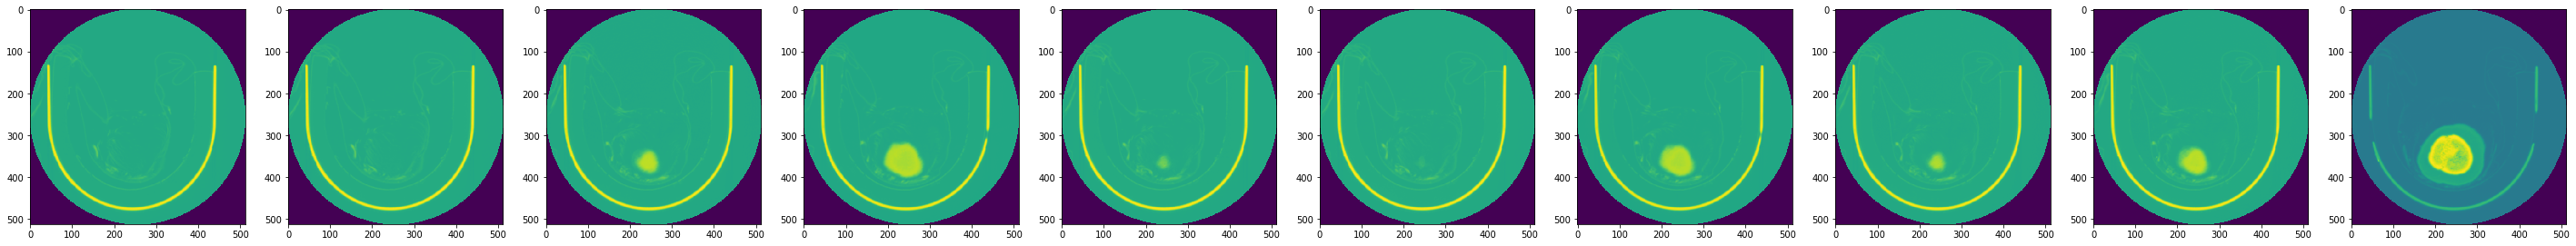

In [0]:
#visualize images
plt.figure(figsize=(50,50))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(img[i])

In [0]:
#create pytorch dataset and dataloaders
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import utils, transforms

class QureaiDS(Dataset):
  def __init__(self, data_frame, transform=None):
    self.df = data_frame
    self.transform = transform
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    label = self.df['R1:ICH'][idx]
    label = np.array(label)
    image_path = self.df['image_path'][idx]
    image = read_dicom_using_sitk(image_path)
    return image, label
    

In [0]:
dataset = QureaiDS(df)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
dataiter = iter(dataloader)
images,label = dataiter.next()
images.shape